In [35]:
import os
import sys
import numpy as  np
import matplotlib.pyplot as plt
from PIL import  Image
import pandas
from matplotlib.pyplot import imshow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers

In [36]:
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print("The parent directory is:", parent_directory)
sys.path.append(parent_directory)

The parent directory is: c:\Users\kkosara\ImageAutoEncoder


In [37]:
from Data import get_image_data
from Models import encoder_model, decoder_model, VAE, load_model_vae
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
# Sampling layer
class Sampling(layers.Layer):
    "used to sample a vector in latent space with learned mean - z_mean and (log) variance - z_log_var"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        vec_len = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, vec_len))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the encoder model
def encoder_model_gs(input_shape, filters, dense_layer_dim, latent_dim):
    """
    Creates an encoder model for grayscale images that maps input images to a lower-dimensional latent space.
    
    Args:
    - input_shape: Tuple representing the shape of the input images (height, width, channels).
    - filters: List of integers representing the number of filters in each convolutional layer.
    - dense_layer_dim: Integer representing the number of neurons in the dense layer.
    - latent_dim: Integer representing the dimensionality of the latent space.
    
    Returns:
    - encoder: Keras Model object representing the encoder model.
    - encoder_layers_dim: List of tuples representing the dimensionality of each layer in the encoder.
    """
    # Create input layer
    encoder_layers_dim = []  # List to store the dimensions of each layer in the encoder
    
    # Define the input layer
    encoder_inputs = tf.keras.Input(shape=input_shape)
    encoder_layers_dim.append(tuple(encoder_inputs.shape[1:]))  # Add input layer dimensions to list
    
    # Add convolutional layers with specified number of filters and activation function
    x = layers.Conv2D(filters[0], (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
    encoder_layers_dim.append(tuple(x.shape[1:]))  # Add conv layer dimensions to list
    x = BatchNormalization()(x)
    # Add additional convolutional layers with specified number of filters and activation function
    mid_layers = [layers.Conv2D(f, 3, activation="relu", strides=2, padding="same") for f in filters[1:]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
        x = BatchNormalization()(x)
        encoder_layers_dim.append(tuple(x.shape[1:]))  # Add mid layer dimensions to list
    
    # Flatten convolutional output to prepare for dense layers
    x = layers.Flatten()(x)
    encoder_layers_dim.append(tuple(x.shape[1:]))  # Add flattened layer dimensions to list
    
    # Add dense layer with specified number of neurons and activation function
    x = layers.Dense(dense_layer_dim, activation='relu')(x)
    
    # Add output layers for latent space (mean and variance) and sample from this space
    z_mean = layers.Dense(latent_dim, name = "z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder_layers_dim.append(tuple(z.shape[1:]))  # Add output layer dimensions to list
    
    # Create encoder model
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim

# decoder model for grayscale images
def decoder_model_gs(encoder_layers_dim):
    # Extract necessary dimensions from encoder model output
    latent_dim = encoder_layers_dim[-1][0]
    dense_layer_dim = encoder_layers_dim[-2][0]
    first_conv_layer_dim = encoder_layers_dim[-3]
    output_layer = encoder_layers_dim[0]

    # Create input layer for latent space vector
    latent_inputs = tf.keras.Input(shape=(latent_dim,))

    # Determine number of filters for each transpose convolutional layer
    filters = [f[-1] for f in encoder_layers_dim[1:-2]]

    # Feed latent vector through a dense layer with ReLU activation
    # Note that we apply the first filter in the form of dense and reshape it
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(dense_layer_dim, activation="relu")(x)
    x = layers.Reshape(first_conv_layer_dim)(x)

    # Apply series of transpose convolutional layers with ReLU activation and same padding and Upsampling
    mid_layers = [layers.Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same") for f in filters[::-1]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
        x = BatchNormalization()(x)

    # Apply final convolutional layer with sigmoid activation to output reconstructed image
    decoder_outputs = layers.Conv2DTranspose(output_layer[-1], 3, activation="sigmoid", padding="same")(x)

    # Create and return Keras model with latent vector as input and reconstructed image as output
    return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

def ssim_loss(y_true, y_pred):
    # Compute the negative SSIM between y_true and y_pred
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    loss = 1.0 - ssim
    return loss

# VAE for GrayScale Images
class VAE_RBG(tf.keras.Model):
    """
    This is a Variational Autoencoder (VAE) implemented using the Keras Model API. It has an encoder and a decoder network defined separately and passed to the constructor as arguments. The VAE class inherits from the Keras Model class and overrides the train_step() method to define the training loop.

    During forward pass, the encoder takes an input image and outputs the mean and standard deviation of a latent space distribution, as well as a sampled vector from that distribution. The decoder takes the sampled vector and outputs a reconstructed image.

    The training loop consists of computing the reconstruction loss and the KL divergence loss, and then computing gradients and updating weights using the Adam optimizer. The reconstruction loss measures the difference between the input image and the reconstructed image, while the KL divergence loss measures the divergence between the latent space distribution and a standard normal distribution. The total loss is the sum of the two losses.

    The VAE class also defines three metrics to track during training: the total loss, the reconstruction loss, and the KL divergence loss. These metrics are updated in the train_step() method and can be accessed via the metrics property. The train_step() method returns a dictionary of these metrics.
    
    """
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # Define metrics to track during training
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # Define forward pass
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

    # Define training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass through encoder and decoder
            z_mean, z_log_var, z, reconstruction = self(data)
            
            # Compute reconstruction loss
            #tf.keras.losses.MeanAbsoluteError()
            # tf.keras.losses.MeanSquaredError()
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.MeanAbsoluteError()(data, reconstruction))
            # ssim = tf.image.ssim(data, reconstruction, max_val=1.0)
            # reconstruction_loss = 1.0 - ssim
            # Compute KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Compute total loss
            total_loss = reconstruction_loss + 1e5*kl_loss
            
        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics as dictionary
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

class VAECallbackRGB(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_dataset, n=10):
        self.vae = vae
        self.test_dataset = test_dataset
        self.n = n
    
    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        test_batch = next(iter(self.test_dataset))
        _, _, _, reconstructed_images = self.vae.predict(test_batch)

        # Rescale pixel values to [0, 1]
        reconstructed_images = np.clip(reconstructed_images, 0.0, 1.0)

        # Plot the original and reconstructed images side by side
        plt.figure(figsize=(10, 20))
        for i in range(self.n):
            plt.subplot(10, 2, 2*i+1)
            plt.imshow(test_batch[i])
            plt.axis('off')
            plt.subplot(10, 2, 2*i+2)
            plt.imshow(reconstructed_images[i])
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()


C:\\Users\\kkosara\\eight_30_hz
Total number of imges: 155135
(56, 56, 3)


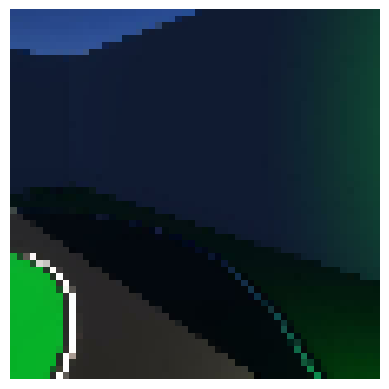

(56, 56, 3)


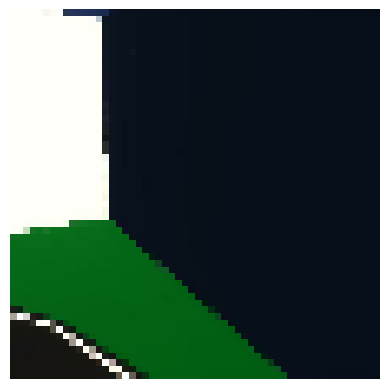

(56, 56, 3)


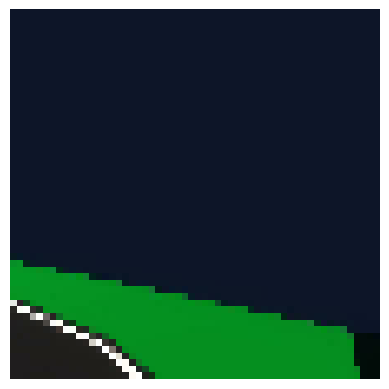

(56, 56, 3)


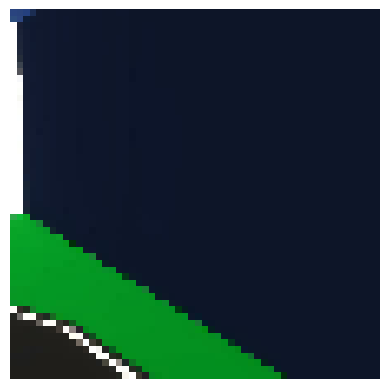

(56, 56, 3)


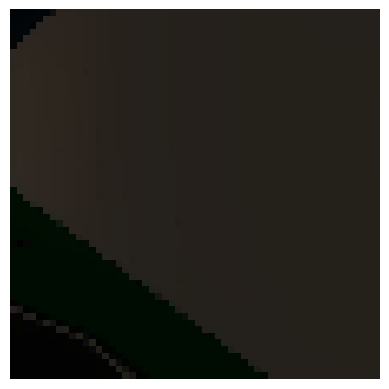

In [39]:
# The directory path where your image data is stored
# all_dirs = ['/home/kkosara/AutoDRIVE-Nigel-Dataset/fishhook_30_hz', '/home/kkosara/AutoDRIVE-Nigel-Dataset/skidpad_30_hz', '/home/kkosara/AutoDRIVE-Nigel-Dataset/slalom_30_hz']
DATA_DIR =  [r'C:\\Users\\kkosara\\eight_30_hz'] # C:\Users\kkosara\eight_30_hz
OUTPUT_IMAGE_SHAPE = 56
INPUT_SHAPE = (OUTPUT_IMAGE_SHAPE, OUTPUT_IMAGE_SHAPE, 3)
FILTERS = [32, 64]
NUM_CONV_LAYERS = len(FILTERS)
DENSE_LAYER_DIM = 16
LATENT_DIM = 20
BETA = 1.0
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 1e-4
PATIENCE = 10
EPOCHS  = 2
TRAIN_SPLIT = 0.8
LOGDIR = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
GRAYSCALE = True

# all_image_paths = get_image_data(DATA_DIR)
# image_count = len(all_image_paths)

# Create a dataset from the list of image file paths
all_image_paths = get_image_data(DATA_DIR)
image_count = len(all_image_paths)

# Create a dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)

# Shuffle the dataset with a buffer size of 1000 and seed of 42
dataset = dataset.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

# Load and preprocess the images
def load_and_preprocess_image(path, shape=(OUTPUT_IMAGE_SHAPE, OUTPUT_IMAGE_SHAPE)):
    # Load the image file
    image = tf.io.read_file(path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the desired size
    image = tf.image.resize(image, shape)
    # Normalize the pixel values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image

dataset = dataset.map(load_and_preprocess_image)
for image in dataset.take(5):
    image_np = image.numpy() # convert to a NumPy array
    print(image.shape)
    # create a PIL Image object from the NumPy array
    pil_image = Image.fromarray(np.uint8(image_np*255))
    # Display the image using Matplotlib
    # plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    # plot the image using matplotlib
    plt.imshow(pil_image)
    plt.show()
# Split the dataset into training and validation sets
train_dataset = dataset.take(int(TRAIN_SPLIT * image_count))
val_dataset = dataset.take(int((1-TRAIN_SPLIT) * image_count))
# train_dataset = train_dataset.shuffle(buffer_size=500, seed=42)
train_dataset = train_dataset.shuffle(buffer_size=500, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=500, seed=42)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [40]:
encoder, encoder_layers_dim = encoder_model_gs(input_shape = INPUT_SHAPE, filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
print(encoder.summary())
print(encoder_layers_dim)
decoder = decoder_model_gs(encoder_layers_dim)
print(decoder.summary())
vae = VAE_RBG(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 28, 28, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [41]:
vae_callback = VAECallbackRGB(vae, val_dataset)

history = vae.fit(train_dataset, epochs=300, callbacks=[vae_callback])


Epoch 1/300
684/970 [====================>.........] - ETA: 18s - loss: 46.6831 - reconstruction_loss: 0.1014 - kl_loss: 7.3126e-05